In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from flowField import *
from flowFieldWavy import *
import h5py
import numpy as np
import pdb
import cProfile
import time
from pseudo import *
from scipy.linalg import norm, svd
from scipy.sparse.linalg import gmres, LinearOperator
from scipy.optimize import newton_krylov,root,anderson
import exactRiblet as rib
import os
import resource
import sys

import matplotlib.pyplot as plt
%matplotlib inline

#figureFolder = "/home/sabarish/Dropbox/reports/2016/equilibria/figures/"
figureFolder = './figures/'
docFolder = "./doc/figures/"
#%run test_flowFieldWavy.py
resnormFun = lambda x: x.residuals().appendField(x.slice(nd=[0,1,2]).div()).norm()

In [3]:
rib.testExactRibletModule(L=4,M=8,epsArr=np.array([0.,0.]),sigma2=True)
rib.testExactRibletModule()
rib.testExactRibletModule(L=3,M=5,sigma1=False,sigma2=True)

Testing for symmetries sigma1=True and sigma2=True to tolerance 1e-13
sigma1 invariance norm of x is 2.47608646991e-16
sigma2 invariance norm of x is 8.13089735302e-17
Success for both tests!
*******************************
Testing for symmetries sigma1=True and sigma2=False to tolerance 1e-13
sigma1 invariance norm of x is 2.47552219356e-16
Success for both tests!
*******************************
Testing for symmetries sigma1=False and sigma2=True to tolerance 1e-13
sigma2 invariance norm of x is 8.05386083249e-17
Success for both tests!
*******************************


(True, True)

In [3]:
x = loadh5('ribEq1L7M10N30E0000.hdf5')
#x = vf.appendField(pf)
x.flowDict['epsArr'] = np.array([0.,0.05,0.0])
#vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,tol=1.0e-06,complexType=np.complex64)
x0 = x.copy()

In [4]:
x.checkSymms()

{'others': 'Maybe',
 'sigma1': True,
 'sigma1Tol': 4.7733994576028647e-11,
 'sigma2': True,
 'sigma2Tol': 5.4493320372916875e-12,
 'sigma3': True,
 'sigma3Tol': 4.804402724809413e-11,
 'tol': 0.27407748155617606}

In [5]:
x = x.slice(L=5,M=12)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)

J, F = rib.makeSystem(vf=vf, pf=pf, sigma1=True, sigma2=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.


1542.636

In [6]:
sys.getsizeof(J)/1000./1000.

1401.753712

In [7]:
x = x.slice(L=3, M=5,N=20)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=4, sigma1=True,sigma2=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

Initial residual norm is 0.0123
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: 1.23182843665e-16
Beginning line search.... Initial residual norm is  0.0123444248651
Line search.... normArr is [ 0.01557606  0.01492212  0.0142715   0.01362464  0.01298207  0.01234442
  0.01171248  0.0110872   0.01046974  0.00986158  0.00926453  0.00868091
  0.00811361  0.00756634  0.00704381  0.00655198  0.00609837  0.00569219
  0.00534439  0.00506711  0.00487256  0.00477104  0.00476866  0.00486577
  0.00505683  0.00533195]
Minimal norm is obtained for q in q*dx of 1.7, producing norm of 0.00477
Finer line search.... normArr is [ 0.00477104  0.00476628  0.00476253  0.00475978  0.00475803  0.00475729
  0.00475755  0.00475882  0.0047611   0.00476438  0.00476866  0.00477394
  0.00478022  0.00478749  0.00479575  0.004805    0.00481522  0.00482642
  0.00483858  0.0048517 ]
Minimal norm is obtained for q in q*dx of 1.6, producing norm of 0.00476
Residual norm after 1 

243.424

In [11]:
x = x.slice(L=2,M=4,N=16)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
J0,F0 = rib.makeSystem(vf = vf, pf=pf, sigma1=True, sigma2=False)
J1,F1 = rib.makeSystem(vf = vf, pf=pf, sigma1=True, sigma2=True)
dx0, linNorm0, jRank0,sVals0 = np.linalg.lstsq(J0,-F0,rcond=1.0e-06)
dx1, linNorm1, jRank1,sVals1 = np.linalg.lstsq(J1,-F1,rcond=1.0e-06)

In [12]:
dx00 = dx0.reshape((5,5,4,16))
dx10 = dx1.reshape((3,5,4,16))

In [14]:
chebnorm((dx10 - dx00[:3]), x.N), chebnorm(dx0,x.N), chebnorm(dx1,x.N)

(4.5780222352279112e-11, 0.069613189638311715, 0.069164941168132724)

In [16]:
compArr = np.array([-1.,-1.,1.,1.]).reshape((1,1,4,1))
lArr = np.arange(-2,0).reshape((2,1,1,1))
mArr = np.arange(-4,1).reshape((1,5,1,1))
diff = dx10[:2] - (-1.)**(lArr + mArr) * compArr * dx00[:2:-1,:,:,::-1]


In [18]:
dxff = x.zero()
dxff[0,:,:5] = dx00
lArr = np.arange(-2.,3.).reshape((5,1,1,1)); mArr = np.arange(-4.,0.).reshape((1,4,1,1))
compArr = np.array([1.,1.,-1.,1.]).reshape((1,1,4,1))
dxff[0,:,:4:-1] = (-1.)**lArr * compArr * dxff[0,:,:4]
chebnorm(diff, x.N), dxff.checkSymms()

(5.2646390627711403e-12,
 {'others': 'Maybe',
  'sigma1': True,
  'sigma1Tol': 3.9698261074899694e-12,
  'sigma2': True,
  'sigma2Tol': 2.2725410649570218e-12,
  'sigma3': True,
  'sigma3Tol': 4.5742722358385639e-12,
  'tol': 6.6844061971765285})

In [20]:
chebnorm(np.dot(J0,dx0)+F0, x.N), chebnorm(np.dot(J1,dx1)+F1, x.N)

(5.5045997833282667e-16, 1.5048909745482435e-16)

In [10]:
x = x.slice(L=4, M=7,N=30)
x.flowDict.update({'eps':0.05,'epsArr':np.array([0.,0.05])})
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=2, sigma1=True,sigma2=True)

Initial residual norm is 0.0122
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: 4.52713093809e-06
Beginning line search.... Initial residual norm is  0.0122229371985
Line search.... normArr is [ 0.01455873  0.01404704  0.01355525  0.01308563  0.01264063  0.01222294
  0.01183545  0.01148123  0.01116345  0.01088529  0.01064987  0.01046008
  0.01031844  0.01022696  0.010187    0.01019918  0.01026332  0.01037847
  0.01054296  0.01075455  0.01101054  0.01130793  0.01164355  0.01201422
  0.01241682  0.01284836]
Minimal norm is obtained for q in q*dx of 0.9, producing norm of 0.0102
Finer line search.... normArr is [ 0.01022696  0.01022063  0.01021482  0.01020952  0.01020475  0.01020049
  0.01019675  0.01019353  0.01019083  0.01018866  0.010187    0.01018587
  0.01018526  0.01018518  0.01018561  0.01018657  0.01018805  0.01019005
  0.01019257  0.01019562]
Minimal norm is obtained for q in q*dx of 0.93, producing norm of 0.0102
Residual norm after 1 t

# Validating solver with laminar flows

In [4]:
flowDict = getDefaultDict()
flowDict.update({'L':1, 'M':6,'N':30,'alpha':5.,'beta':10.,'eps':0.05,'epsArr':np.array([0.,0.05]),'Re':100.,'isPois':0})

start = time.time()
vf = flowFieldRiblet(flowDict=flowDict).view4d()
vf[0,vf.nx//2,vf.nz//2,0] = vf.y
pf = vf.getScalar().zero()

vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,doLineSearch=False,rcond=1.0e-07)
print('runTime(s):',time.time()-start)
vf0 = vf.copy(); pf0 = pf.copy()

Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: 1.44466512874e-14
Residual norm after 1 th iteration is 7.76e-14
Converged in  1  iterations. Returning....................................
runTime(s): 21.76744270324707


0.0

# Plots for JFMrapids

## Residual norms, accuracy, energy density, bulk dissipation rate

In [3]:
#%%%%%%%%%%%%%%%%%%%%
# eps_1

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e1/'
nSol = 21 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][1]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

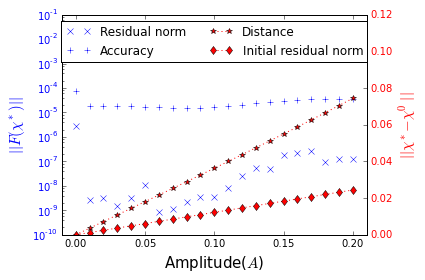

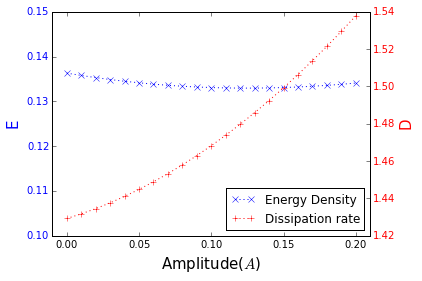

In [4]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE1.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE1.eps',format='eps',dpi=1200)
plt.show()


In [5]:
#%%%%%%%%%%%%%%%%%%%%
# eps_2

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e2/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][2]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

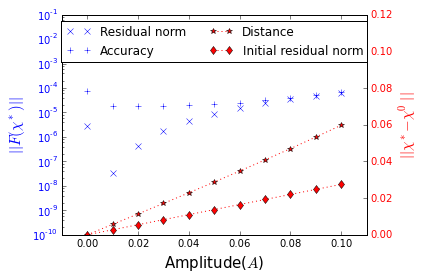

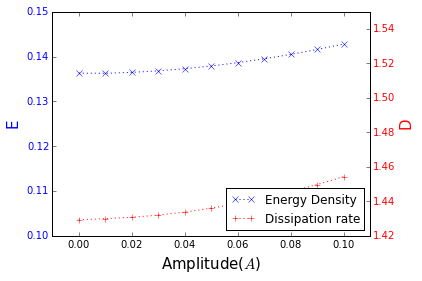

In [9]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE2.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE2.eps',format='eps',dpi=1200)
plt.show()


In [10]:
#%%%%%%%%%%%%%%%%%%%%
# eps_3

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e3/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][3]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

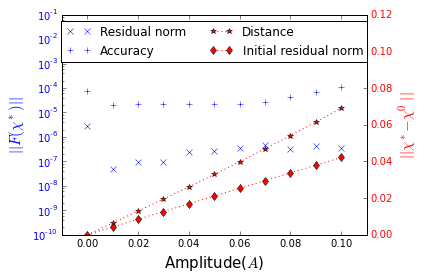

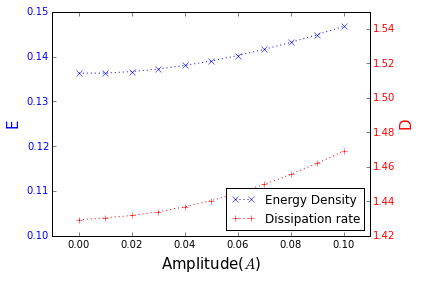

In [11]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE3.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE3.eps',format='eps',dpi=1200)
plt.show()


In [91]:
figureFolder = './figures/'
#%%%%%%%%%%%%%%%%%%%%
# eps_3

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros((3,nSol))   # Residual norm of converged solutions
accArr = np.zeros((3,nSol))       # Accuracy of solutions w.r.t grid size
distArr = np.zeros((3,nSol))      # Distance from x0
energyArr = np.zeros((3,nSol))    # Energy density
dissipationArr = np.zeros((3,nSol)) # Bulk dissipation rate
pInputArr = np.zeros((3,nSol))      # 
initialnormArr = np.zeros((3,nSol))
epsArr = np.zeros((3,nSol))

resnormArr[:,0] = resnormFun(x0.slice(M=16,N=30))
accArr[:,0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[:,0] = 0.
energyArr[:,0] = x0.energy(); dissipationArr[:,0] = x0.dissipation(); pInputArr[:,0] = x0.powerInput()
#initialnormArr[:,0] = resnormArr[0]
for k in range(1,nSol):
    # eps_1
    solPath = loadPath+'e1/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[0,k] = x.flowDict['epsArr'][1]
    resnormArr[0,k] = resnormFun(x)
    accArr[0,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[0,k] = (x-x0).norm()
    
    energyArr[0,k] = x.energy()
    dissipationArr[0,k] = x.dissipation()
    pInputArr[0,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[0,k] = resnormFun(x)
    
    # eps_2
    solPath = loadPath+'e2/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[1,k] = x.flowDict['epsArr'][2]
    resnormArr[1,k] = resnormFun(x)
    accArr[1,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[1,k] = (x-x0).norm()
    
    energyArr[1,k] = x.energy()
    dissipationArr[1,k] = x.dissipation()
    pInputArr[1,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[1,k] = resnormFun(x)

    # eps_3
    solPath = loadPath+'e3/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[2,k] = x.flowDict['epsArr'][3]
    resnormArr[2,k] = resnormFun(x)
    accArr[2,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[2,k] = (x-x0).norm()
    
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    pInputArr[2,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[2,k] = resnormFun(x)
    


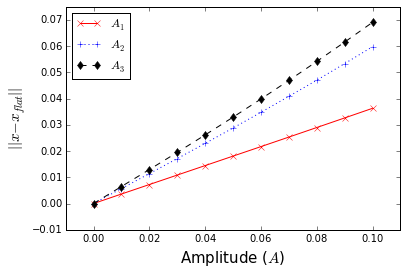

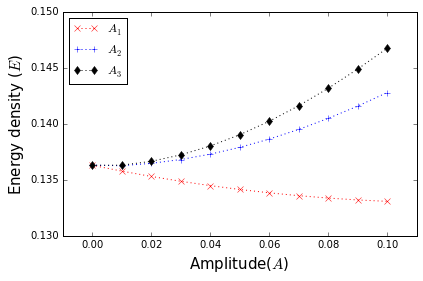

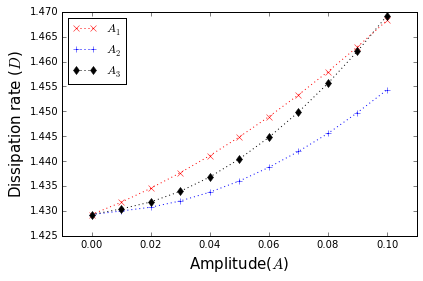

In [97]:
# Residual norm, accuracy, and distance
plt.figure()
plt.plot(2.*epsArr[0], distArr[0],'rx-')
plt.plot(2.*epsArr[1], distArr[1],'b+:')
plt.plot(2.*epsArr[2], distArr[2],'kd--')
plt.legend(['$A_1$', '$A_2$', '$A_3$'], loc=2)
plt.xlabel('Amplitude ($A$)',fontsize=15); plt.ylabel('$||x-x_{flat}||$', fontsize=15)
plt.ylim([-0.01,0.075]); plt.xlim([-0.01,0.11])
plt.savefig(figureFolder+'normDistE123.eps',format='eps',dpi=1200)
plt.show()

# Energy density and bulk dissipation rate
plt.figure()
plt.plot(2.*epsArr[0], energyArr[0],'rx:',label='$A_1$')
plt.plot(2.*epsArr[1], energyArr[1],'b+:',label='$A_2$')
plt.plot(2.*epsArr[2], energyArr[2],'kd:',label='$A_3$')
plt.xlim([-0.01,0.11])
plt.ylim([0.13,0.15])
plt.legend(loc=2)
plt.xlabel('Amplitude($A$)',fontsize=15); plt.ylabel('Energy density ($E$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyE123.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[0], dissipationArr[0],'rx:',label='$A_1$')
plt.plot(2.*epsArr[1], dissipationArr[1],'b+:',label='$A_2$')
plt.plot(2.*epsArr[2], dissipationArr[2],'kd:',label='$A_3$')
plt.xlim([-0.01,0.11])
plt.legend(loc=2)
plt.xlabel('Amplitude($A$)',fontsize=15); plt.ylabel('Dissipation rate ($D$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'dissipationE123.eps',format='eps',dpi=1200)
plt.show()


## Phase-difference

In [13]:
# eps_1 = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A05/ribEq1L7M16N35E1_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



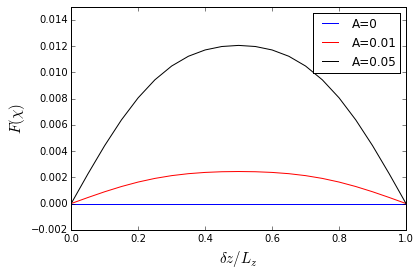

In [14]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE1.eps',format='eps',dpi=1200)
plt.show()

In [20]:
#%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A05/ribEq1L7M16N35E1_001E2_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))    


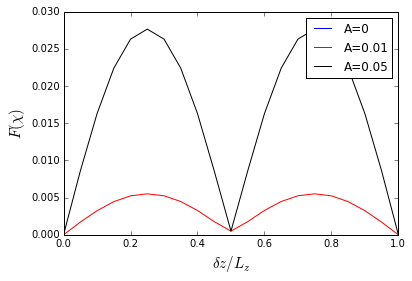

In [21]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE2.eps',format='eps',dpi=1200)
plt.show()

In [17]:
#%%%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



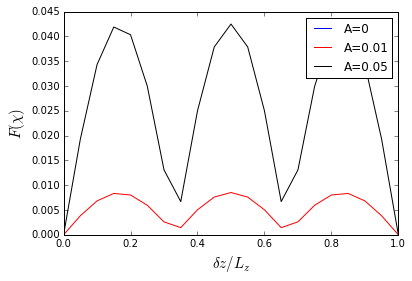

In [19]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE3.eps',format='eps',dpi=1200)
plt.show()

In [78]:
#%%%%%%%%%%%%%%%
# eps_1, eps_2, eps_3
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.025)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

normArrE1 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE1[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

normArrE2 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE2[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

    
    
normArrE3 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE3[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        


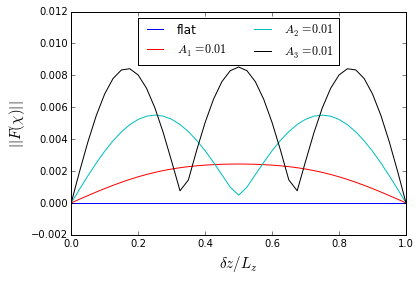

In [80]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrE1,'r')
plt.plot(phaseArrZ/np.pi/2., normArrE2,'c')
plt.plot(phaseArrZ/np.pi/2., normArrE3,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['flat','$A_1=0.01$','$A_2=0.01$', '$A_3=0.01$'],ncol=2,loc='upper center')
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$||F(\\chi)||$",fontsize=15)
plt.ylim([-0.002,0.012])
plt.savefig(figureFolder+'phaseShiftE123.eps',format='eps',dpi=1200)
plt.show()

## Velocity plots

Phase-shifted Eq1 at x0, with A=0, fnorm=6.41e-05


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


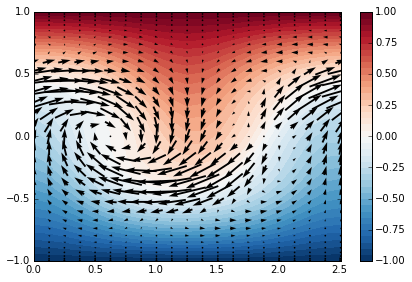

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


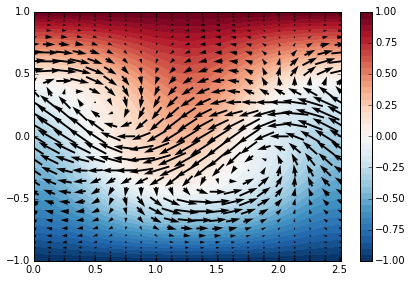

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


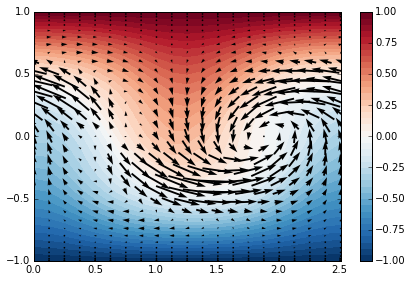

Phase-shifted Eq1 at x0, with A=0.01, fnorm=1.11e-08


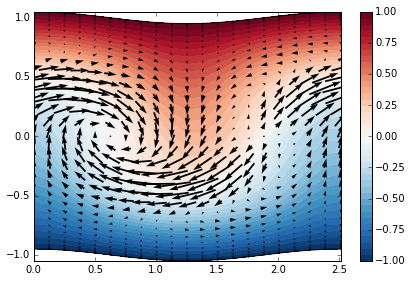

Phase-shifted Eq1 at x1, with A=0.01, fnorm=1.11e-08


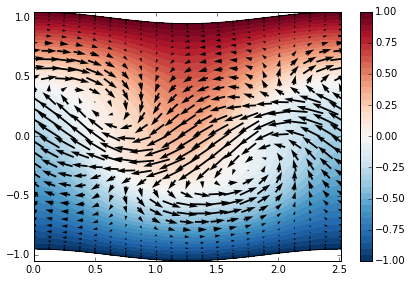

Phase-shifted Eq1 at x1, with A=0.01, fnorm=1.11e-08


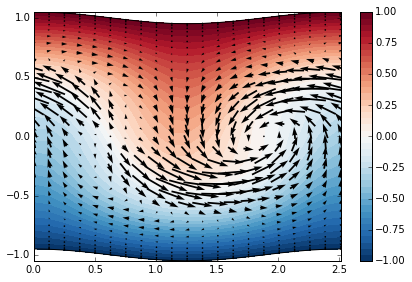

Phase-shifted Eq1 at x0, with A=0.02, fnorm=3.46e-09


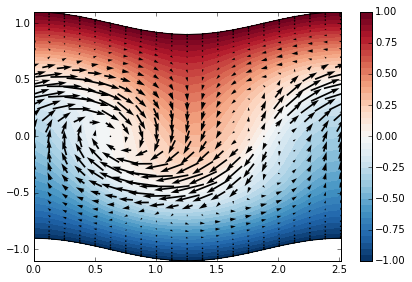

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.46e-09


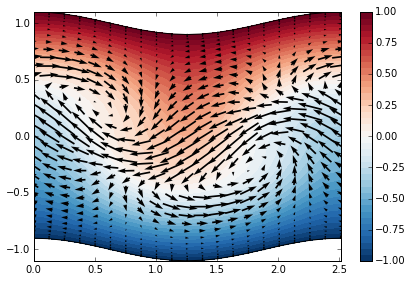

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.46e-09


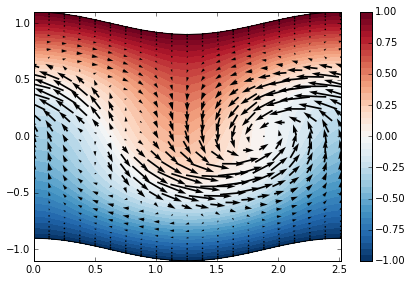

Phase-shifted Eq1 at x0, with A=0.03, fnorm=1.84e-07


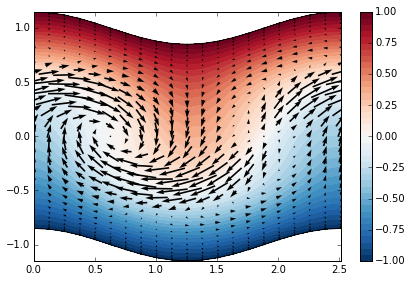

Phase-shifted Eq1 at x1, with A=0.03, fnorm=1.84e-07


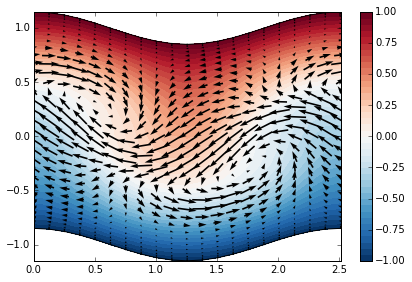

Phase-shifted Eq1 at x1, with A=0.03, fnorm=1.84e-07


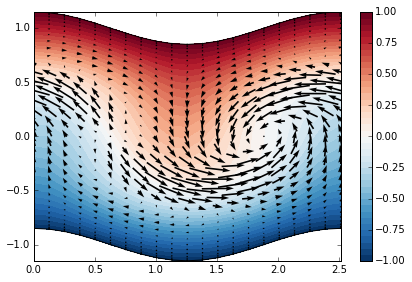

In [95]:
loadPath = 'solutions/e1/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_050.hdf5'))
xList.append(loadh5(loadPath+'A15/ribEq1L7M16N35E1_075.hdf5'))
fNameList = ['A00','A05','A10','A15']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; eps = vf.flowDict['eps']; A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE1_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


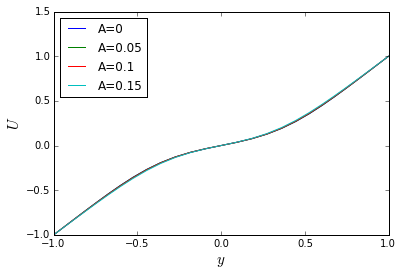

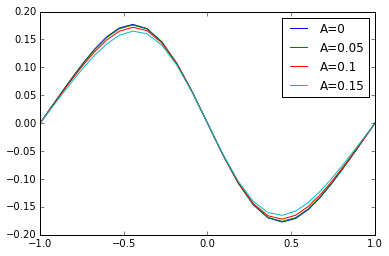

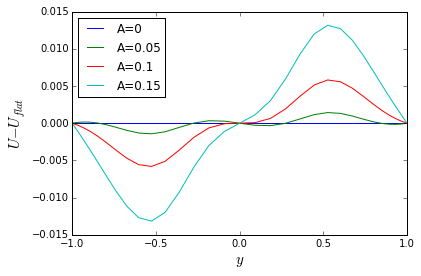

In [42]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE1.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE1.eps',format='eps',dpi=1200)
plt.show()

Phase-shifted Eq1 at x0, with A=0, fnorm=6.41e-05


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


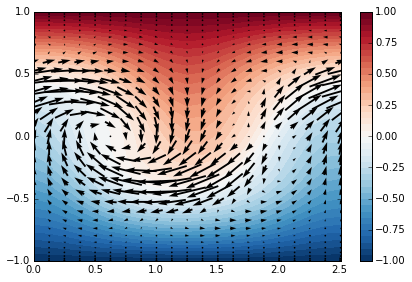

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


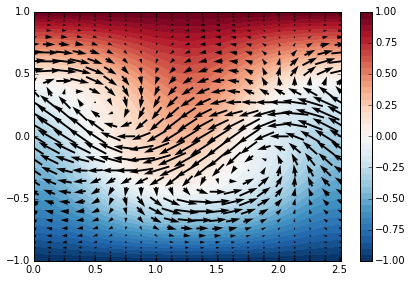

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


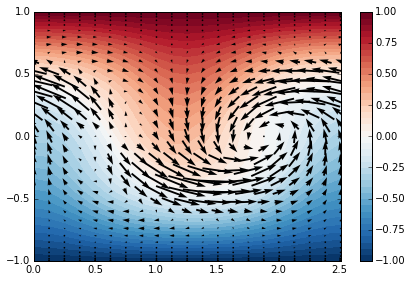

Phase-shifted Eq1 at x0, with A=0.01, fnorm=8.83e-06


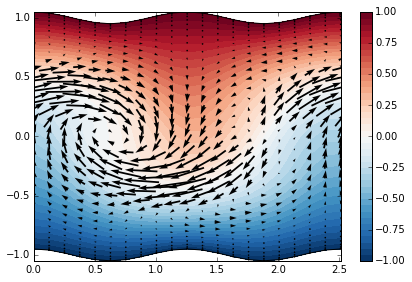

Phase-shifted Eq1 at x1, with A=0.01, fnorm=8.83e-06


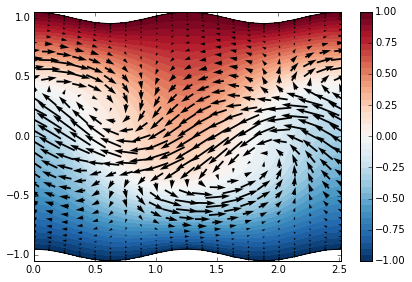

Phase-shifted Eq1 at x1, with A=0.01, fnorm=8.83e-06


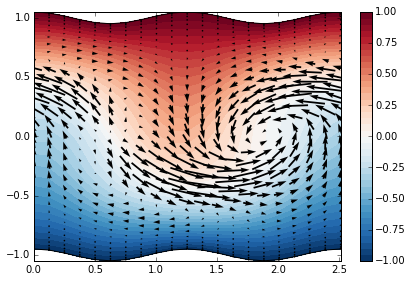

Phase-shifted Eq1 at x0, with A=0.02, fnorm=6.32e-05


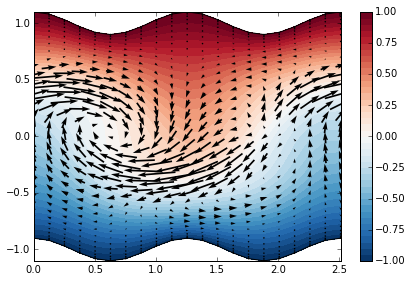

Phase-shifted Eq1 at x1, with A=0.02, fnorm=6.32e-05


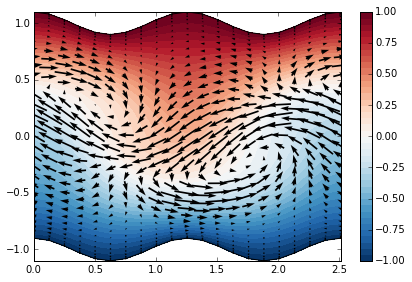

Phase-shifted Eq1 at x1, with A=0.02, fnorm=6.32e-05


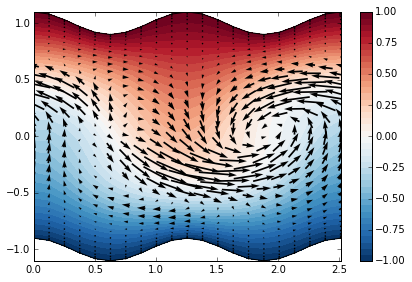

In [96]:
#%%%%%%%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%%%%%%%%
loadPath = 'solutions/e2/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; 
    if k > 0:
        eps = vf.flowDict['epsArr'][2]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(2.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE2_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


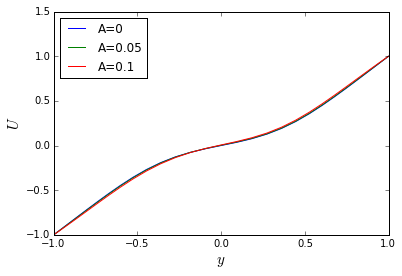

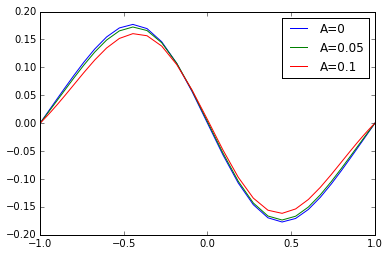

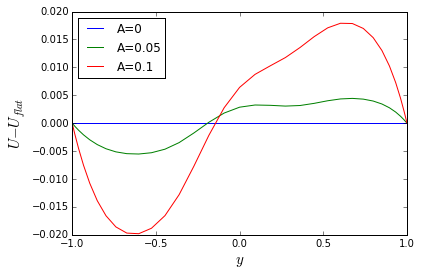

In [40]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE2.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE2.eps',format='eps',dpi=1200)
plt.show()

Phase-shifted Eq1 at x0, with A=0, fnorm=6.41e-05


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


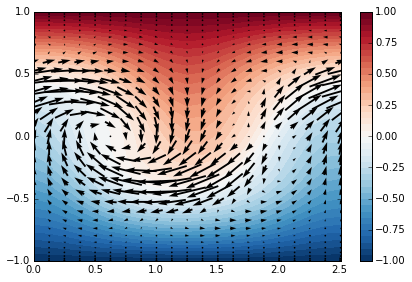

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


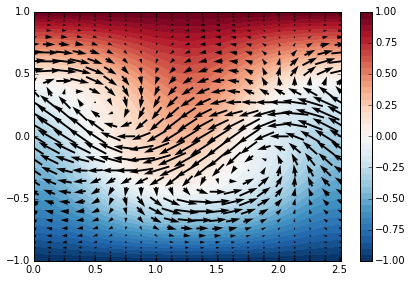

Phase-shifted Eq1 at x1, with A=0, fnorm=6.41e-05


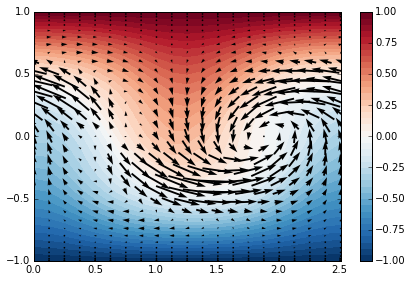

Phase-shifted Eq1 at x0, with A=0.01, fnorm=2.77e-07


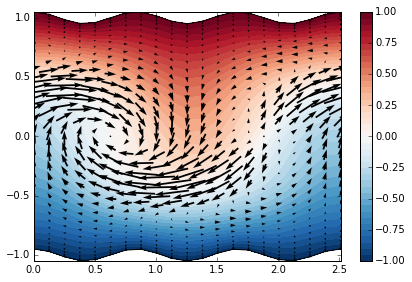

Phase-shifted Eq1 at x1, with A=0.01, fnorm=2.77e-07


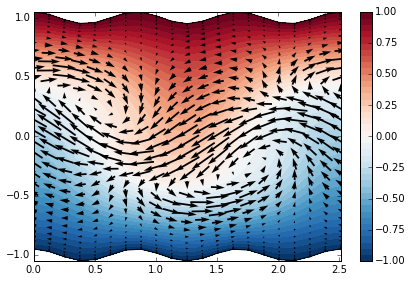

Phase-shifted Eq1 at x1, with A=0.01, fnorm=2.77e-07


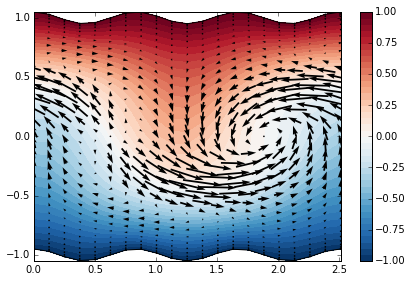

Phase-shifted Eq1 at x0, with A=0.02, fnorm=3.55e-07


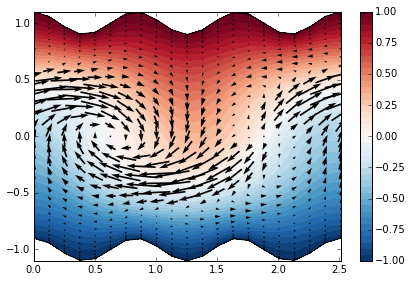

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.55e-07


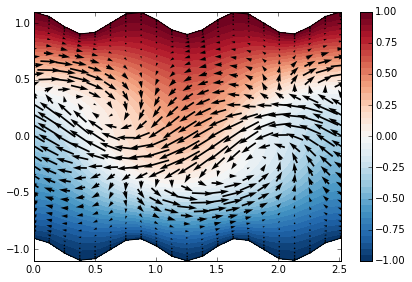

Phase-shifted Eq1 at x1, with A=0.02, fnorm=3.55e-07


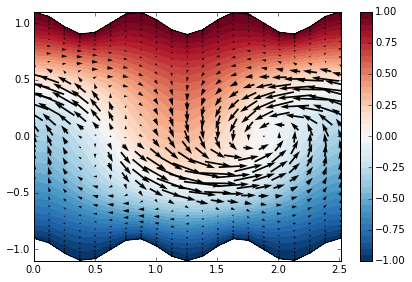

In [97]:
#%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
loadPath = 'solutions/e3/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_000E3_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b
    if k > 0:
        eps = vf.flowDict['epsArr'][3]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(3.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE3_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


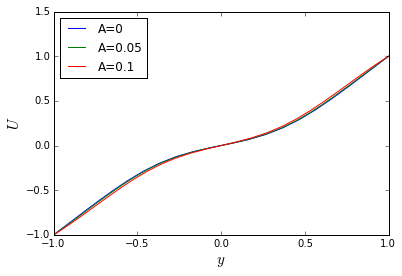

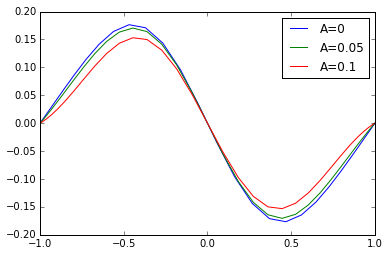

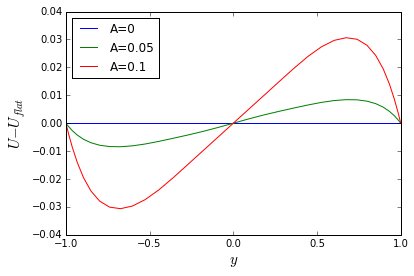

In [37]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE3.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE3.eps',format='eps',dpi=1200)
plt.show()

## Projections on chi^*_0

## Direction of perturbation from flat-walled solution

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


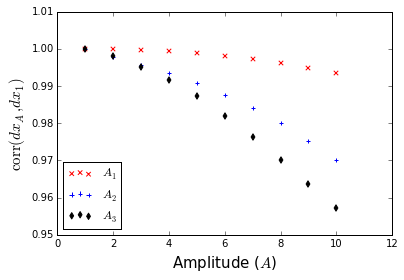

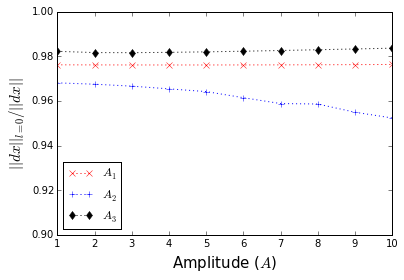

In [111]:
def makeReal(x):
    x[0,:] = 0.5*(x + np.conj(x[0,::-1,::-1]))
    return

x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
makeReal(x0)
nSol = 11
corrArr = np.zeros((3,nSol))
energyArr = np.zeros((3,nSol))

x1 = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e1/'
    fName = 'A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[0,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Setting l=0 modes to zero in dx
    norm0 = dx.norm()
    energyArr[0,k] = dx.slice(L=0).norm()**2/norm0**2
    
x1 = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e2/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[1,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Energy in l=0
    norm0 = dx.norm()
    energyArr[1,k] = dx.slice(L=0).norm()**2/norm0**2
    
x1 = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e3/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[2,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Setting l=0 modes to zero in dx
    norm0 = dx.norm()
    energyArr[2,k] = dx.slice(L=0).norm()**2/norm0**2
    
plt.figure()
plt.scatter(np.arange(1,nSol),np.real(corrArr[0,1:]),c='r',marker='x')
plt.scatter(np.arange(1,nSol),np.real(corrArr[1,1:]),c='b',marker='+')
plt.scatter(np.arange(1,nSol),np.real(corrArr[2,1:]),c='k',marker='d')
plt.ylim([0.95, 1.01])
plt.legend(['$A_1$','$A_2$','$A_3$'],loc=3)
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('$\\mathrm{corr}(dx_A, dx_1)$',fontsize=15)
plt.savefig(figureFolder+'pertCorr.eps',format='eps',dpi=1200)
plt.show()


plt.figure()
plt.plot(np.arange(1,nSol),np.real(energyArr[0,1:]),'rx:')
plt.plot(np.arange(1,nSol),np.real(energyArr[1,1:]),'b+:')
plt.plot(np.arange(1,nSol),np.real(energyArr[2,1:]),'kd:')
plt.ylim([0.9, 1.0])
plt.legend(['$A_1$','$A_2$','$A_3$'],loc=3)
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('$||dx||_{l=0}/||dx||$',fontsize=15)
plt.savefig(figureFolder+'pertEnergyL0.eps',format='eps',dpi=1200)
plt.show()


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


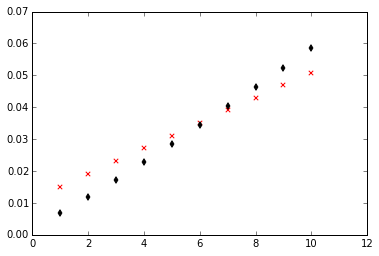

In [68]:
def makeReal(x):
    x[0,:] = 0.5*(x + np.conj(x[0,::-1,::-1]))
    return

x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
makeReal(x0)
nSol = 11
corrArr = np.zeros((3,nSol))
energyArr = np.zeros((3,nSol))

for k in range(1,nSol):
    loadPath = 'solutions/e1/'
    fName = 'A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    
    xLam = loadh5('solutions/laminar/lamL0M7N35E1_%03d.hdf5'%(5*k))
    makeReal(xLam)
    dxLam = xLam.copy()
    dxLam[0,xLam.nx//2, xLam.nz//2] -= xLam.y
    #dxLam.flowDict.update({'alpha':dx.flowDict['alpha']})
    dxLam = dxLam.slice(L=7,M=16,N=35)
    
    corrArr[0,k] = dx.dot(dxLam)/dx.norm()/dxLam.norm()

for k in range(1,nSol):
    loadPath = 'solutions/e3/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    
    xLam = loadh5('solutions/laminar/lamL0M15N35E1_001E2_000E3_%03d.hdf5'%(5*k))
    makeReal(xLam)
    dxLam = xLam.copy()
    dxLam[0,xLam.nx//2, xLam.nz//2] -= xLam.y
    #dxLam.flowDict.update({'alpha':dx.flowDict['alpha']})
    dxLam = dxLam.slice(L=7,M=16,N=35)
    
    corrArr[2,k] = dx.dot(dxLam)/dx.norm()/dxLam.norm()

    
plt.figure()
plt.scatter(np.arange(1,nSol),np.real(corrArr[0,1:]),c='r',marker='x')
plt.scatter(np.arange(1,nSol),np.real(corrArr[2,1:]),c='k',marker='d')
#plt.ylim([0.75, 1.01])
plt.show()


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


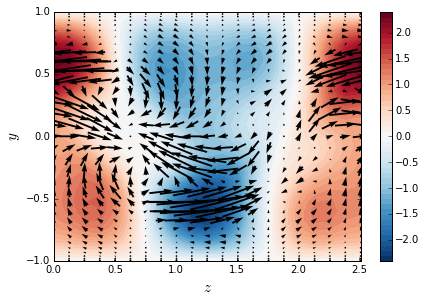

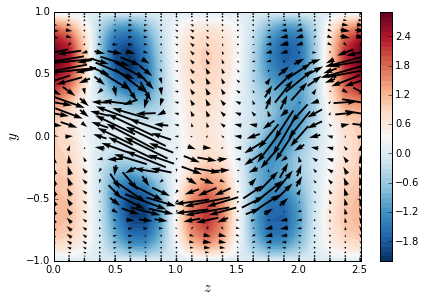

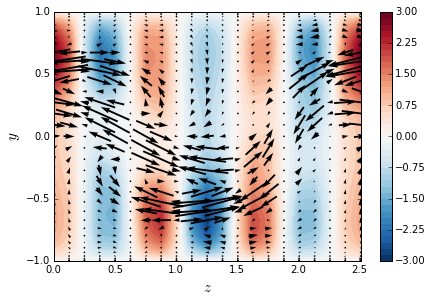

In [90]:
#%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
loadPath = 'solutions/'
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35); makeReal(x0)
dxList = []
x=loadh5(loadPath+'e1/A01/ribEq1L7M16N35E1_005.hdf5');makeReal(x)
dxList.append(x-x0)
x=loadh5(loadPath+'e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5');makeReal(x)
dxList.append(x-x0)
x=loadh5(loadPath+'e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5');makeReal(x)
dxList.append(x-x0)
fNameList = ['E1','E2','E3']
for k in range(len(dxList)):    
    x = dxList[k]
    x = x/x.slice(nd=[0,1,2]).norm()
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b
    if k > 0:
        eps = vf.flowDict['epsArr'][k]
    else: 
        eps = 0.
    #A = 2.*eps
    A = 0.
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(3.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'pertA01_'+fName

    #uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    #plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.contourf(Z[0], Y[0], u[0], 50,cmap=plt.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.75,scale_units='y',pivot='middle')
    #print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    plt.xlabel('$z$',fontsize=15); plt.ylabel('$y$',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()



In [58]:
x = loadh5('solutions/laminar/lamL0M15N35E1_001E2_000E3_005.hdf5').slice(L=7,M=16,N=35)
#dx = x.copy()
#dx[0,dx.nx//2,dx.nz//2,0] -= dx.y
#dx.norm()

In [59]:
x.residuals().norm()

0.00099418371949685841

## Running for laminar solutions

In [ ]:
epsArr = np.arange(0.005,0.0501,0.005)

flowDict = getDefaultDict()
flowDict.update({'L':0, 'M':7,'N':35,'nd':3})
vf0 = flowFieldRiblet(flowDict=flowDict.copy())
vf0[0, vf0.nx//2, vf0.nz//2, 0] = vf0.y

if False:
    # eps_1
    for eps in epsArr:
        print('Iterating for eps_1 =',eps)
        vf = vf0.copy()
        vf.flowDict.update({'eps':eps,'epsArr':np.array([0., eps])})
        pf = vf.getScalar().zero()
        vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
        x = vf.appendField(pf)
        x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
        print('residual norm:',x.residuals().norm());print('');print('')
    
# eps_2
vf0 = vf0.slice(M=10)
for eps in epsArr:
    print('Iterating for eps_2 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001, eps])})
    pf = vf.getScalar().zero()
    
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
    print('residual norm:',x.residuals().norm());print('');print('')

    
# eps_3
vf0 = vf0.slice(M=15)
for eps in epsArr:
    print('Iterating for eps_3 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001,0., eps])})
    pf = vf.getScalar().zero()
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
    print('residual norm:',x.residuals().norm());print('');print('')

    

In [ ]:
if False:
    # What happens if I restrict equilibrium to streamwise-homogeneous?
    x = loadh5('solutions/e3/A10/ribEq1L7M16N35E1_001E2_000E3_050.hdf5')
    x = x.slice(L=0)
    x.flowDict['alpha'] = 0.
x = loadh5('solutions/laminar/lamRibEq1L0M16N35E1_001E2_000E3_050.hdf5')
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf,pf,fnorm,flg = rib.iterate(vf=vf,pf=pf,iterMax=100)
x = vf.appendField(pf)
x.saveh5(prefix='solutions/laminar/',fNamePrefix='lamRibEq1')
print('resnorm:',x.residuals().norm())

# Extrapolation from A=0.01

In [89]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.1001,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = eps
    x.flowDict['epsArr'] = np.array([0.,eps])
    fileStr = 'solutions/e1/A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



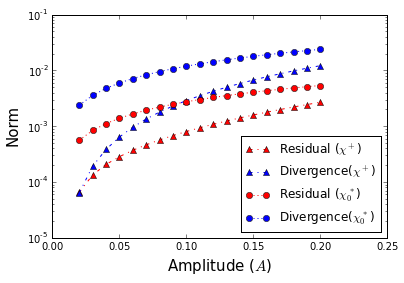

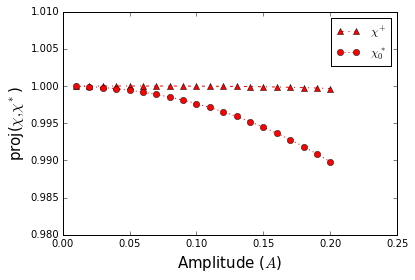

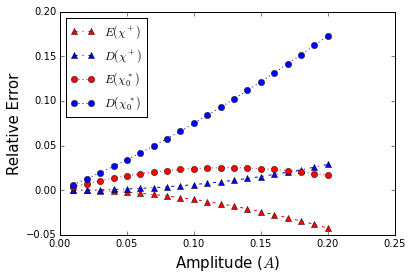

In [90]:
fName='E1'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()




In [91]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.0501,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = 0.001
    x.flowDict['epsArr'] = np.array([0.,0.001,0.,eps])
    fileStr = 'solutions/e3/A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



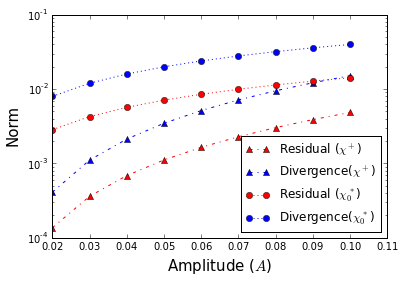

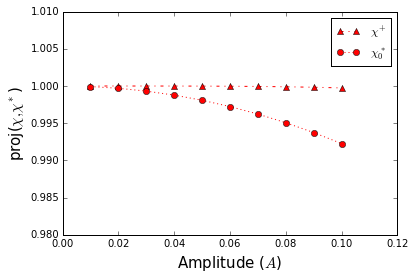

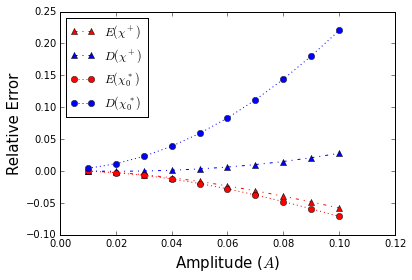

In [92]:
fName='E3'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()






In [93]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.0501,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = 0.001
    x.flowDict['epsArr'] = np.array([0.,0.001,eps])
    fileStr = 'solutions/e2/A%02d/ribEq1L7M16N35E1_001E2_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



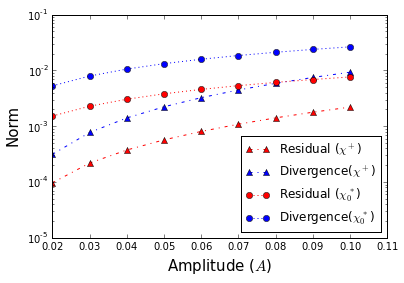

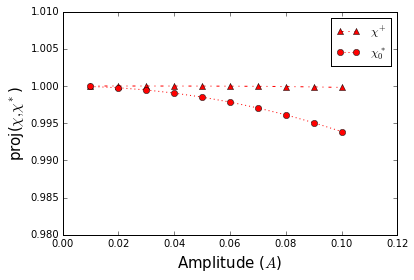

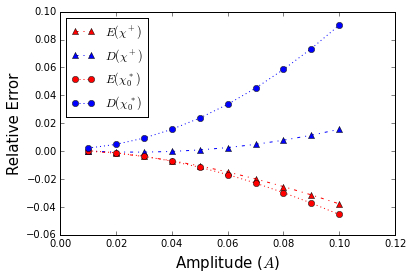

In [94]:
fName='E2'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()





## Solver with reflectional symmetry

In [39]:
sigma1 = True
L = 3; M=5; N=20; eps = 0.05
x = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=L,M=M,N=N)
x.flowDict.update({'eps':eps, 'epsArr':np.array([0.,eps])})
flowDict = x.flowDict
Lmat = rib.linr(flowDict,sigma1=sigma1)
#x[0,:,:,0] = 0.
vf = x.slice(nd=[0,1,2])

In [40]:

Lmat[:] = 0.

if sigma1:
    nz1 = vf.nz//2 + 1
else:
    nz1 = vf.nz

a = vf.flowDict['alpha']; b = vf.flowDict['beta']
epsArr = vf.flowDict['epsArr']
q0 = epsArr.size-1
Tz = Tderivatives(vf.flowDict)[0]
N = vf.N; L = vf.nx//2; M = vf.nz//2; N4 = 4*N

# No reason to keep accessing flowFieldRiblet with all its extra machinery
#   Copy elements to a regular numpy array instead
vfArr = vf.view4d().copyArray()
u = vfArr[0,:,:,0]; v = vfArr[0,:,:,1]; w = vfArr[0,:,:,2]
vfyArr = vf.ddy().view4d().copyArray()
uy = vfyArr[0,:,:,0]; vy = vfyArr[0,:,:,1]; wy = vfyArr[0,:,:,2]
# The state-vectors aren't that big, so memory isn't an issue

D = vf.D; I = np.identity(vf.N, dtype=Lmat.dtype); Z = np.zeros((vf.N,vf.N),dtype=Lmat.dtype)
D.astype(Lmat.dtype)

# Index of the first row/column of the block for any wavenumber vector (l,m)
iFun = lambda l,m: (l+L)*(nz1*4*N) + (m+M)*4*N

Gmat = Lmat
assert (Gmat.shape[0] == vf.nx*nz1*4*N) and (Gmat.shape[1] == vf.nx*nz1*4*N)

# I will be using the functions np.diag() and np.dot() quite often, so,
diag = np.diag; dot = np.dot

# Final piece of notation: 
ia = 1.j*a; ib = 1.j*b

if sigma1:
    M1 = 1
else:
    M1 = M+1

    
# The convection term has this form:
# phi^{lm}_{1,2,3} = \sum_lp \sum_mp  u_{l-lp,m-mp} u_{lp,mp}  , 
#    disregarding the surface influence terms. 
# Gmat is the actual non-linear jacobian
# G is a temporary matrix created for each 'lp' in equations for each (l,m) in the Jacobian,
# If sigma1 is to be imposed,
#    G is folded and multiplied with (-1)**lp before being assigned to the
#        corresponding rows and columns in Gmat
# Otherwise, G is added as is
G = np.zeros((4*N, vf.nz*4*N), dtype=np.complex)


for l in range(-L,L+1):
    for m in range(-M,M1):
        # Index of first row in the block for equations for wavenumbers (l,m)
        rInd = iFun(l,m)
        # l1,m2 are the wavenumbers in phi^j_{lm}

        for lp in range(-L,L+1):
            G[:] = 0.    # Getting rid of G from previous 
            rInd = 0     # We're only writing equations for one l,m, lp
            # G contains the part of the Jacobian that multiplies the mode (lp,:)
            #    in the equations for (l,m)
            # I will define this without assuming symmetries
            # When adding to Gmat, I will fold G on itself
            
            for mp in range(-M,M+1):
                #cInd = iFun(lp,mp)
                cInd = iFun(-L,mp)  # Because I'm writing G for only one 'l'
                if (-L <= (l-lp) <= L):
                    li = l-lp+L # Array index for streamwise wavenumber l-lp

                    # First, all the terms not relating to wall-effects
                    if (-M <= (m-mp) <= M):
                        mi = m-mp+M # Array index for spanwise wavenumber m-mp
                        # phi^1_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+0*N : rInd+1*N , cInd+0*N : cInd+1*N ] += \
                                ( l*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + diag(w[li,mi])*mp*ib )
                        # phi^1_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+0*N : rInd+1*N , cInd+1*N : cInd+2*N ] += (diag(uy[li, mi]))
                        # phi^1_{l,m}: factors of terms with  w_{lp,mp}
                        G[ rInd+0*N : rInd+1*N , cInd+2*N : cInd+3*N ] += ((m-mp)*ib*diag(u[li, mi]))

                        # phi^2_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+1*N : cInd+2*N ] += \
                                (    lp*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + diag(w[li,mi])*mp*ib \
                                + diag(vy[li,mi])   )
                        # phi^2_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+0*N : cInd+1*N ] += ((l-lp)*ia*diag(v[li, mi])  )
                        # phi^2_{l,m}: factors of terms with  w_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+2*N : cInd+3*N ] += ((m-mp)*ib*diag(v[li, mi])  )

                        # phi^3_{l,m}: factors of terms with  w_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+2*N : cInd+3*N ] += \
                                (  lp*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + m*ib*diag(w[li,mi])  )
                        # phi^3_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+1*N : cInd+2*N ] += (   diag(wy[li, mi]) )
                        # phi^3_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+0*N : cInd+1*N ] += (   (l-lp)*ia*diag(w[li, mi])  )

                    # Now, the terms arising due to wall effects
                    # The interactions in l are unaffected since Tz only have e^iqb

                    for q in range(-q0,q0+1):

                        if (-M <= (m-mp+q) <= M):
                            mi = m-mp+q+M # Array index for spanwise wavenumber m-mp
                            # phi^1_{l,m}: factors of terms with u_{lp,mp}
                            G[ rInd+0*N : rInd+1*N , cInd+0*N : cInd+1*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D 
                            # phi^1_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+0*N : rInd+1*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* diag(uy[li,mi]) 

                            # phi^2_{l,m}: factors of terms with v_{lp,mp}
                            G[ rInd+1*N : rInd+2*N , cInd+1*N : cInd+2*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D 
                            # phi^2_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+1*N : rInd+2*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* diag(vy[li,mi]) 

                            # phi^3_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+2*N : rInd+3*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D \
                                    +Tz[q0-q]* diag(wy[li,mi]) 
            # Now, G is ready to be folded if sigma1 holds
            if sigma1:
                if False:
                    Gtemp = np.zeros((4*N, M+1, 4*N), dtype=Gmat.dtype)
                    Gnew = G.reshape((4*N, vf.nz, 4,N))
                    Gnew[:, M:,2] = -1.* Gnew[:, M:, 2]   # w-factors need to be multiplied with an extra -1
                    # Because sigma1 goes u_{l,m} = (-1)^l  u_{l,-m} (same for v and p)
                    #               but   w_{l,m} = (-1)^{l+1} w_{l,-m}
                    Gnew = Gnew.reshape((4*N, vf.nz, 4*N))

                    Gtemp[:] = Gnew[:, :M+1]   # Factors of non-positive modes are assigned as are
                    Gtemp[:,:M] += (-1.)**lp  * Gnew[:, :M:-1]   # Need to assign M to -M, (M-1) to -(M-1) and so on..
                    # Reshaping to a matrix
                    Gtemp = Gtemp.reshape((4*N, nz1*4*N))
                    # And that's it. We're ready to add to Gmat
                else:
                    Gtemp = G[:, nz1*4*N:].reshape((4*N, M, 4*N))
                    Gtemp = Gtemp[:,::-1]
                    Gtemp[:,:, 2*N:3*N] *= -1.
                    Gtemp = Gtemp.reshape((4*N, M*4*N))
                    
                    
                
            
            cInd = iFun(lp, -M)
            rInd = iFun(l,m)
            Gmat[rInd: rInd+4*N, cInd: cInd+nz1*4*N] = G[:,:nz1*4*N]
            if sigma1:
                Gmat[rInd: rInd+4*N, cInd: cInd+M*4*N] += (-1.)**lp * Gtemp




In [41]:
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3); tol = 1.0e-10
nex = 5

vf1 = vf.slice(L=vf.nx//2+nex, M = vf.nz//2+nex)
pf1 = pf.slice(L=vf.nx//2+nex, M = vf.nz//2+nex)


if sigma1:
    NLterm = 0.5*np.dot(Lmat, x[0,:,:x.nz//2+1].flatten())
else:
    NLterm = 0.5*np.dot(Lmat, x.flatten())

NLtermClassFine = vf1.convNL()
NLtermClass = NLtermClassFine.slice(L=vf.nx//2, M=vf.nz//2).appendField(pf.zero())

if sigma1:
    resnorm =  chebnorm(NLterm - NLtermClass[0,:,:x.nz//2+1].flatten(), x.N)   
else:
    resnorm = chebnorm(NLterm - NLtermClass.flatten(), x.N)

NLtestResult = resnorm <= tol
print(NLtestResult, resnorm)

True 9.26404551451e-13


## Linear truncation in Fourier space

In [15]:
vf = h52ff('../flowFieldV2/Eq/eq1.h5')
pf = h52ff('../flowFieldV2/Eq/pres_eq1.h5',pres=True)
x = vf.appendField(pf).view4d()

In [19]:
Larr = np.array([5,7,10,13]).astype(np.int)
Marr = np.array([8,10, 12, 14]).astype(np.int)
lRes = np.zeros(4); mRes = np.zeros(4); lmRes1 = np.zeros(4); lmRes2 = np.zeros(4)
L = x.nx//2; M = x.nz//2
for k in range(4):
    l = Larr[k]; m = Marr[k]
    print(l,m)
    lRes[k] = chebnorm(x[0,L-l,M],x.N)
    mRes[k] = chebnorm(x[0,L,M-m],x.N)
    lmRes1[k] = chebnorm(x[0, L-l//2, M-m//2], x.N)
    lmRes2[k] = chebnorm(x[0,L-l, M-m], x.N)

print(lRes, mRes, lmRes1, lmRes2)
#

5 8
7 10
10 12
13 14


(array([  2.13337929e-08,   8.90165841e-10,   3.88845015e-12,
          1.90206826e-14]),
 array([  2.43102202e-06,   9.41609587e-08,   3.05031517e-09,
          4.51618894e-11]),
 array([  7.88327586e-04,   1.68746559e-04,   6.96107548e-06,
          1.27063418e-06]),
 array([  4.50486234e-06,   1.67196035e-07,   2.46033137e-09,
          7.28494881e-11]))

In [23]:
for l in range(16,31):
    print(chebnorm(x[0,l,M],x.N), chebnorm(x[0,l,l],x.N))

# Modes (l,l) seem to have more energy than modes (l,0). Clearly, linear truncation is a bad idea.

8.90165841484e-10 1.88693964535e-07
4.60051171812e-09 1.01804660052e-06
2.13337929416e-08 5.54246733638e-06
1.07167504406e-06 3.09160122884e-05
7.85349674366e-06 0.000183808376044
0.000302089427628 0.00132661071739
0.0117174337015 0.0149768808373
0.698410977629 0.698410977629
0.0117174337015 0.0149768808373
0.000302089427628 0.00132661071739
7.85349674366e-06 0.000183808376044
1.07167504406e-06 3.09160122884e-05
2.1333792941e-08 5.54246733638e-06
4.6005117181e-09 1.01804660052e-06
8.90165841123e-10 1.88693964536e-07
